## Model output And Metric reseach

In [1]:
import keras 
import tensorflow as tf 
import keras.backend as K

Using TensorFlow backend.
/Users/hyunkim/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/hyunkim/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/hyunkim/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16",

In [2]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("./dataset/selfie/training/00694.png", cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256,256))
img = np.concatenate([img, np.ones((256,256,1))], axis=-1)[np.newaxis,:,:,:]
img = img / 255.

mask = cv2.imread("./dataset/selfie/training/00694_matte.png", cv2.IMREAD_GRAYSCALE)
mask = cv2.resize(mask, (256,256))



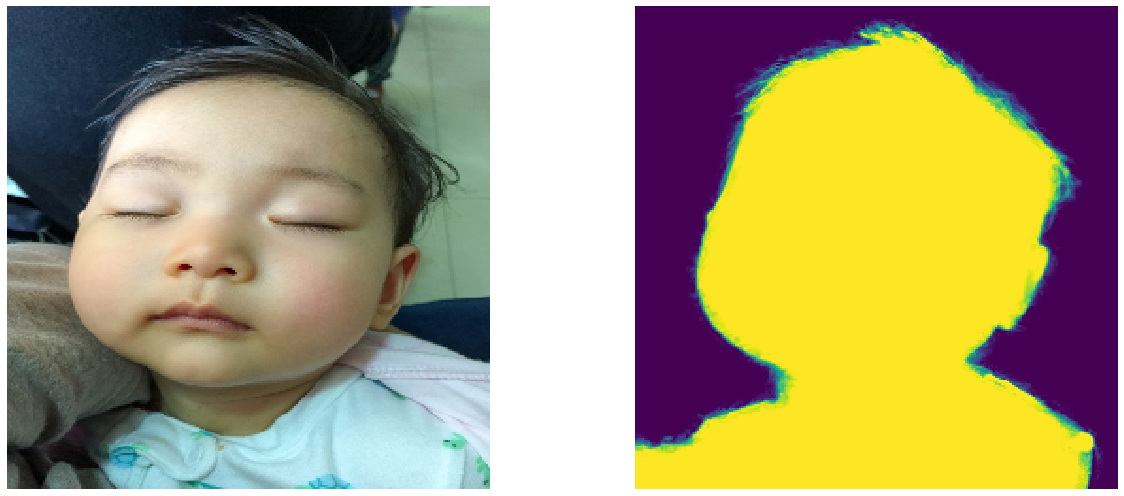

In [3]:
plt.figure(figsize=(19,7))
plt.subplot(121)
plt.imshow(img.squeeze(0)[:,:,:3])
plt.axis("off")

plt.subplot(122)
plt.imshow(mask)
plt.axis("off")

plt.tight_layout()
plt.show()

## Thresholded mask


(-0.5, 255.5, 255.5, -0.5)

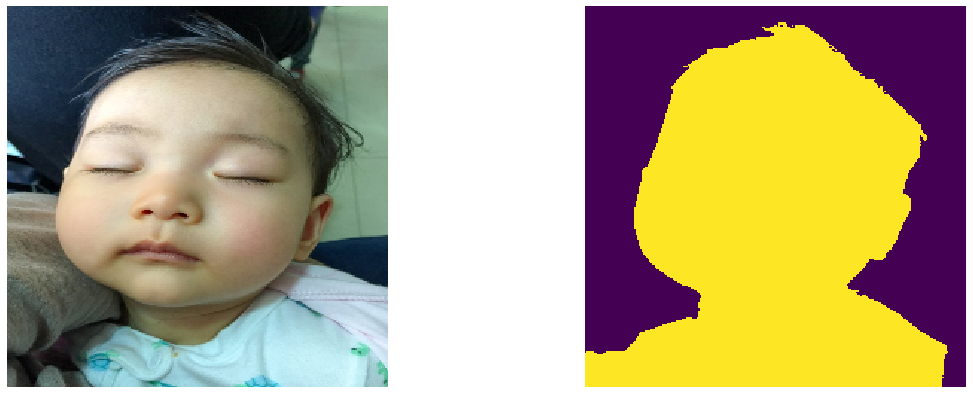

In [4]:
plt.figure(figsize=(19,7))
plt.subplot(121)
plt.imshow(img.squeeze(0)[:,:,:3])
plt.axis("off")

plt.subplot(122)
plt.imshow(cv2.threshold(mask, 150, 255, cv2.THRESH_BINARY)[1])
plt.axis("off")

In [5]:
mask_ = tf.constant(cv2.threshold(mask, 20, 255, cv2.THRESH_BINARY)[1]/ 255.)
pred_ = tf.constant(cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)[1] / 255.)

In [6]:
mask_ = tf.reshape(mask_, (1, 256, 256, 1))
pred_ = tf.reshape(pred_, (1, 256, 256, 1))

In [7]:
def iou_coef(y_true, y_pred, smooth=1):
    
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    threshold = tf.constant(0.5, dtype=tf.float32)
    
    y_true = tf.cast(y_true > threshold, dtype=tf.float32)
    y_pred = tf.cast(y_pred > threshold, dtype=tf.float32)
    
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [8]:
def dice_loss(y_true, y_pred):
    
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
    denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2,3))

    return 1 - numerator / denominator

In [9]:
def focal_loss(alpha=0.25, gamma=2):
    def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
        weight_a = alpha * (1 - y_pred) ** gamma * targets
        weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)
    
        return (tf.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b 

    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, dtype=tf.float32)
        y_pred = tf.cast(y_pred, dtype=tf.float32)

        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        logits = tf.log(y_pred / (1 - y_pred))

        loss = focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)

        # or reduce_sum and/or axis=-1
        return tf.reduce_mean(loss)

    return loss

In [10]:
def ce_dl_combined_loss(y_true, y_pred):
    
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    def dice_loss(y_true, y_pred):
        numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
        denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2,3))

        return tf.reshape(1 - numerator / denominator, (-1, 1, 1))

    return tf.reduce_mean(keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred))


In [11]:
iou = iou_coef(mask_, pred_)
dice = dice_loss(mask_, pred_)
focal = focal_loss()(mask_, pred_)
com = ce_dl_combined_loss(mask_, pred_)

In [12]:
with tf.Session() as sess:
    dice_ = sess.run(dice)
    focal_ = sess.run(focal)
    iou_ = sess.run([iou,])
    com_ = sess.run(com)


### This is the Porper value of the loses and metrics 

In [13]:
dice_, focal_, iou_, com_

(array([0.00592828], dtype=float32), 0.088668786, [0.9882136], 0.119636916)

In [15]:
(com_ + focal_) / 2

0.1041528508067131